In [76]:
import numpy as np

# Import PyTorch
import torch
from torch.autograd import Variable

# Import TensorLy
import tensorly as tl
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.random import check_random_state

In [77]:
tl.set_backend('pytorch')

Using pytorch backend.


Make the results reproducible by fixing the random seed

In [79]:
random_state = 1234
rng = check_random_state(random_state) # seed. To have results be reproduceble
#device = 'cuda:8'
device = 'cpu'

## to just ajust cuda it gives assertion error
## AssertionError: 
## Found no NVIDIA driver on your system. Please check that you
## have an NVIDIA GPU and installed a driver from
## http://www.nvidia.com/Download/index.aspx

Define a random tensor which we will try to decompose. We wrap our tensors in Variables so we can backpropagate through them:



In [82]:
shape = [5, 5, 5]
tensor = tl.tensor(rng.random_sample(shape), device=device, requires_grad=True) 
# can put device as cuda or default device predefined above
# like device = 'cuda:9'

Initialise a random Tucker decomposition of that tensor



In [83]:
ranks = [5, 5, 5]
core = tl.tensor(rng.random_sample(ranks), device=device, requires_grad=True)
factors = [tl.tensor(rng.random_sample((tensor.shape[i], ranks[i])),
                 device=device, requires_grad=True) for i in range(tl.ndim(tensor))]


Now we just iterate through the training loop and backpropagate...



Epoch 1000,. Rec. error: 5.259055251372047e-05
Epoch 2000,. Rec. error: 3.748767267097719e-05
Epoch 3000,. Rec. error: 8.297749445773661e-05
Epoch 4000,. Rec. error: 4.813263876712881e-05
Epoch 5000,. Rec. error: 6.548576493514702e-05
Epoch 6000,. Rec. error: 6.925491470610723e-05
Epoch 7000,. Rec. error: 4.323222310631536e-05
Epoch 8000,. Rec. error: 7.227441528812051e-05
Epoch 9000,. Rec. error: 6.138482422102243e-05
 
[tensor(1.00000e-05 *
       5.2591), tensor(1.00000e-05 *
       3.7488), tensor(1.00000e-05 *
       8.2977), tensor(1.00000e-05 *
       4.8133), tensor(1.00000e-05 *
       6.5486), tensor(1.00000e-05 *
       6.9255), tensor(1.00000e-05 *
       4.3232), tensor(1.00000e-05 *
       7.2274), tensor(1.00000e-05 *
       6.1385)]
tensor(1.00000e-05 *
       3.7488)


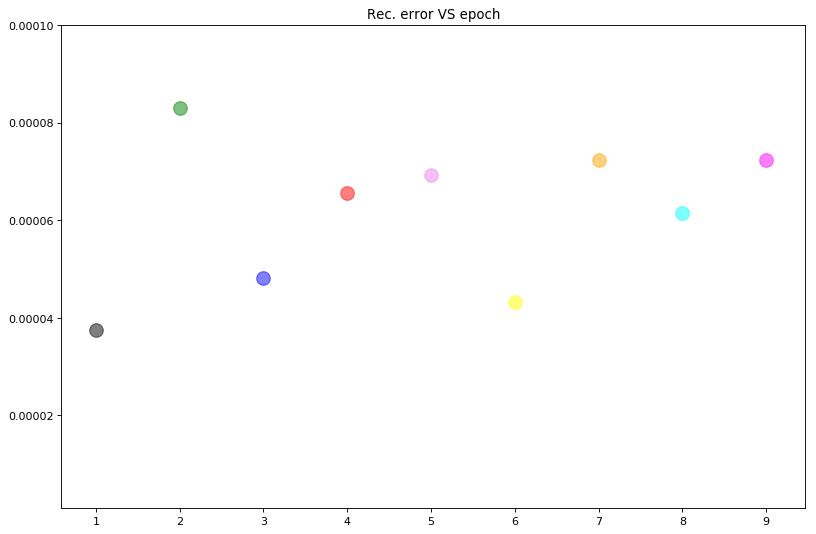

In [100]:
## MO
import matplotlib.pyplot as plt
%matplotlib inline
## MO
#fig = plt.figure()
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
## 
some_list = []


##
n_iter = 10000
lr = 0.00005
penalty = 0.1

optimizer = torch.optim.Adam([core]+factors, lr=lr)
# [core, factors(0), factors(1), ... ] # we can do optimization of the factors we want specially


for i in range(1, n_iter):
    # Important: do not forget to reset the gradients
    optimizer.zero_grad()

    # Reconstruct the tensor from the decomposed form
    rec = tucker_to_tensor(core, factors)

    # squared l2 loss
    loss = tl.norm(rec - tensor, 2)

    # squared l2 penalty on the factors of the decomposition
    for f in factors:
        loss = loss + penalty * f.pow(2).sum()

    loss.backward() # back propagate and mesure reconstruction error
    optimizer.step()

    if i % 1000 == 0:
        rec_error = tl.norm(rec.data - tensor.data, 2)/tl.norm(tensor.data, 2)
        
        print("Epoch {},. Rec. error: {}".format(i, rec_error))
        #print(type(rec_error)) ## <class 'torch.Tensor'>
        #print(rec_error.data)
        some_list.append(rec_error.data)
        #plt.plot(i,rec_error.data) ## MO

print(' ')
print(some_list)

print(some_list[1].data)

#plt.plot(1000,some_list[1].data)
#plt.plot(3000,some_list[3].data)
#plt.plot(5000,some_list[5].data)

plt.ylim(0.000001,0.0001)

plt.scatter(1, some_list[1].data, s=150, c="black", alpha=0.5)
plt.scatter(2, some_list[2].data, s=150, c="green", alpha=0.5)
plt.scatter(3, some_list[3].data, s=150, c="blue", alpha=0.5)
plt.scatter(4, some_list[4].data, s=150, c="red", alpha=0.5)
plt.scatter(5, some_list[5].data, s=150, c="violet", alpha=0.5)
plt.scatter(6, some_list[6].data, s=150, c="yellow", alpha=0.5)
plt.scatter(7, some_list[7].data, s=150, c="orange", alpha=0.5)
plt.scatter(8, some_list[8].data, s=150, c="cyan", alpha=0.5)
plt.scatter(9, some_list[7].data, s=150, c="magenta", alpha=0.5)



plt.title('Rec. error VS epoch')
plt.show()

# Now a CP decomposition

In [110]:
# Create random factors
factors = [tl.tensor(rng.random_sample((s,5)),device=device,requires_grad=True)\
           for s in shape]

In [111]:
[f.shape for f in factors]


[torch.Size([5, 5]), torch.Size([5, 5]), torch.Size([5, 5])]

In [115]:
## DEFINE in other way
factors = []
for s in shape:
    factors.append(tl.tensor(rng.random_sample((s,5)),device=device,requires_grad=True))
    


In [116]:
[f.shape for f in factors]

[torch.Size([5, 5]), torch.Size([5, 5]), torch.Size([5, 5])]

In [119]:
# Optimize them

##
n_iter = 10000
lr = 0.00005
penalty = 0.1

optimizer = torch.optim.Adam(factors, lr=lr)


for i in range(1, n_iter):
    # Important: do not forget to reset the gradients
    optimizer.zero_grad()
    
    # Reconstruct the tensor from the decomposed form
    rec = tl.kruskal_to_tensor(factors)

    # squared l2 loss
    loss = tl.norm(rec - tensor, 2)

    # squared l2 penalty on the factors of the decomposition
    for f in factors:
        loss = loss + penalty * f.pow(2).sum()

    loss.backward() # back propagate and mesure reconstruction error
    optimizer.step()

    if i % 1000 == 0:
        rec_error = tl.norm(rec.data - tensor.data, 2)/tl.norm(tensor.data, 2)
        
        print("Epoch {},. Rec. error: {}".format(i, rec_error))


Epoch 1000,. Rec. error: 0.4924027621746063
Epoch 2000,. Rec. error: 0.49444541335105896
Epoch 3000,. Rec. error: 0.4952702820301056
Epoch 4000,. Rec. error: 0.49557140469551086
Epoch 5000,. Rec. error: 0.49567580223083496
Epoch 6000,. Rec. error: 0.4957085847854614
Epoch 7000,. Rec. error: 0.49571773409843445
Epoch 8000,. Rec. error: 0.4957198202610016
Epoch 9000,. Rec. error: 0.49572011828422546
